# Mean filter benchmarking
This notebook compares different implementations of the Mean filter.

**Note:** benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

In [1]:
import pyclesperanto_prototype as cle
from skimage import filters
import cupy
import cupyx.scipy.ndimage as cuda_ndi
import time
import scipy.ndimage as ndi
import numpy as np
from skimage.morphology import cube
from skimage.io import imshow

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX').name

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [2]:
# test data
test_image = np.random.random([100, 512, 512])

radius = 10
diameter = radius * 2 + 1

In [3]:
image_size_in_mb = np.prod(test_image.shape) * 4 / 1024 / 1024

print("The test image is", image_size_in_mb, "MB large")

The test image is 100.0 MB large


## clEsperanto

In [4]:
# convolve with pyclesperanto
result_image = None

cl_test_image = cle.asarray(test_image)

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.mean_box(cl_test_image, result_image, radius_x=radius, radius_y=radius, radius_z=radius)
    print("pyclesperanto mean filter duration: " + str(time.time() - start_time))

pyclesperanto mean filter duration: 0.05187845230102539
pyclesperanto mean filter duration: 0.041854143142700195
pyclesperanto mean filter duration: 0.04095029830932617
pyclesperanto mean filter duration: 0.04077577590942383
pyclesperanto mean filter duration: 0.041867971420288086
pyclesperanto mean filter duration: 0.03985929489135742
pyclesperanto mean filter duration: 0.037873268127441406
pyclesperanto mean filter duration: 0.03289008140563965
pyclesperanto mean filter duration: 0.03392910957336426
pyclesperanto mean filter duration: 0.034722328186035156


## cupy

In [5]:
# convolve with cupy
result_image = None
cu_test_image = cupy.asarray(test_image)

for i in range(0, 10):
    start_time = time.time()
    result_image = cuda_ndi.uniform_filter(cu_test_image, output=result_image, size=diameter)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy mean filter duration: " + str(time.time() - start_time))

cupy mean filter duration: 0.19434714317321777
cupy mean filter duration: 0.07574868202209473
cupy mean filter duration: 0.07470846176147461
cupy mean filter duration: 0.07479405403137207
cupy mean filter duration: 0.07474708557128906
cupy mean filter duration: 0.07474923133850098
cupy mean filter duration: 0.07574772834777832
cupy mean filter duration: 0.07474613189697266
cupy mean filter duration: 0.0747532844543457
cupy mean filter duration: 0.07575583457946777


## Scipy

In [6]:
# convolve with Scipy
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = ndi.uniform_filter(test_image, output=result_image, size=diameter)
    print("Scipy mean filter duration: " + str(time.time() - start_time))  

Scipy mean filter duration: 0.45555734634399414
Scipy mean filter duration: 0.43155574798583984
Scipy mean filter duration: 0.4137380123138428
Scipy mean filter duration: 0.4285755157470703
Scipy mean filter duration: 0.41262364387512207
Scipy mean filter duration: 0.6786510944366455
Scipy mean filter duration: 0.6906905174255371
Scipy mean filter duration: 0.688697338104248
Scipy mean filter duration: 0.6896939277648926
Scipy mean filter duration: 0.688697099685669


## Visual comparison

In [7]:
radius = 1
diameter = radius * 2 + 1

C:\Users\rober\miniconda3\envs\bio39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


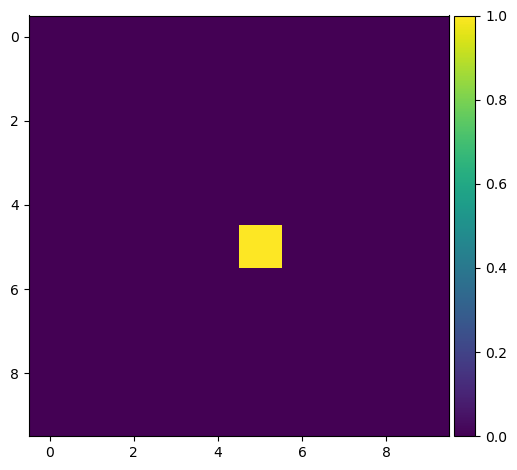

In [8]:
test2d_image = np.zeros((10, 10))
test2d_image[5, 5] = 1

imshow(test2d_image)

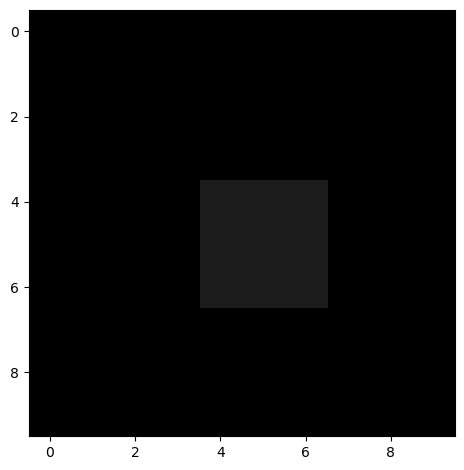

In [9]:
cle_result_image = cle.mean_box(test2d_image, radius_x=radius, radius_y=radius, radius_z=radius)

imshow(cle_result_image)

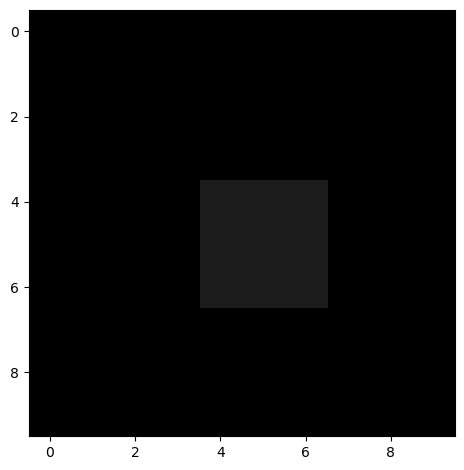

In [10]:
cu_test2d_image = cupy.asarray(test2d_image)

cu_result_image = cuda_ndi.uniform_filter(cu_test2d_image, size=diameter)

imshow(cu_result_image.get())

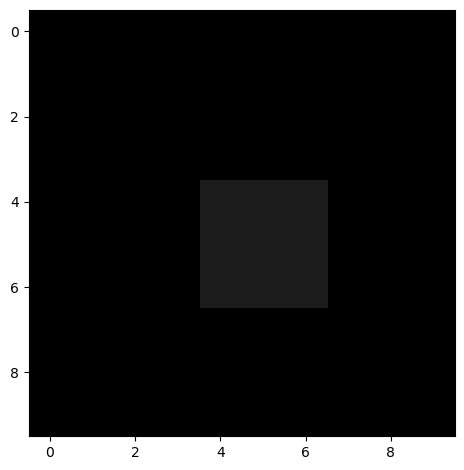

In [11]:
sp_result_image = ndi.uniform_filter(test2d_image, size=diameter)
imshow(sp_result_image)

## Quantitative result comparison


In [12]:
cle.mean_squared_error(cle_result_image, cu_result_image.get())

4.996003610813204e-18

In [13]:
cle.mean_squared_error(cle_result_image, sp_result_image)

4.996003610813204e-18

In [14]:
cle.mean_squared_error(sp_result_image, cu_result_image.get())

0.0